[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/francisco-ortin/data-science-course/blob/main/deep-learning/cnn/object_detection.ipynb)
[![License: CC BY-NC-SA 4.0](https://img.shields.io/badge/License-CC%20BY--NC--SA%204.0-lightgrey.svg)](https://creativecommons.org/licenses/by-nc-sa/4.0/)

# CNN for object detection

CNNs are not only used for image classification. A powerful feature of ANNs is that they can have multiple outputs. Thus, a CNN can be used to not only recognize an object in an image but also localize it in the picture. This is what is called *object detection*.

Localizing an object in a picture can be expressed as a regression task. We have to predict a bounding box around the object: the horizontal and vertical coordinates of the object’s center (two numbers), as well as its height and width (other two). This means we have four numbers to predict (four regression problems). Besides those four numbers, we can also predict the class of the object (classification problem).

This example uses the [MNIST dataset](https://en.wikipedia.org/wiki/MNIST_database) to predict the digit in an image and also localizes its position: digit detection.

In [1]:
# make sure the required packages are installed
%pip install pandas numpy seaborn matplotlib scikit-learn keras tensorflow --quiet
# if running in colab, install the required packages and copy the necessary files
directory='data-science-course/deep-learning/cnn'
if get_ipython().__class__.__module__.startswith('google.colab'):
    !git clone --depth 1 https://github.com/francisco-ortin/data-science-course.git  2>/dev/null
    !cp --update {directory}/*.py .
    !mkdir -p img data
    !cp {directory}/img/* img/.

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.keras as ks
from keras import Input, Model

import utils

Note: you may need to restart the kernel to use updated packages.


## Data preparation

We use the MNIST dataset (train, val and test) from tensor flow. 

In [2]:
BATCH_SIZE = 32
train_dataset, val_dataset = utils.get_train_val_dataset(BATCH_SIZE)
test_dataset = utils.get_test_dataset()

Let's convert the raw dataset tensorflow format to numpy (before its visualization).

In [3]:
(train_digits, train_labels, train_bboxes,
 val_digits, val_labels, val_bboxes,
 test_digits, test_labels, test_bboxes) = \
    utils.dataset_to_numpy_util(train_dataset, val_dataset, test_dataset, 10)

We visualize digits and bounding boxes of train and validation datasets.

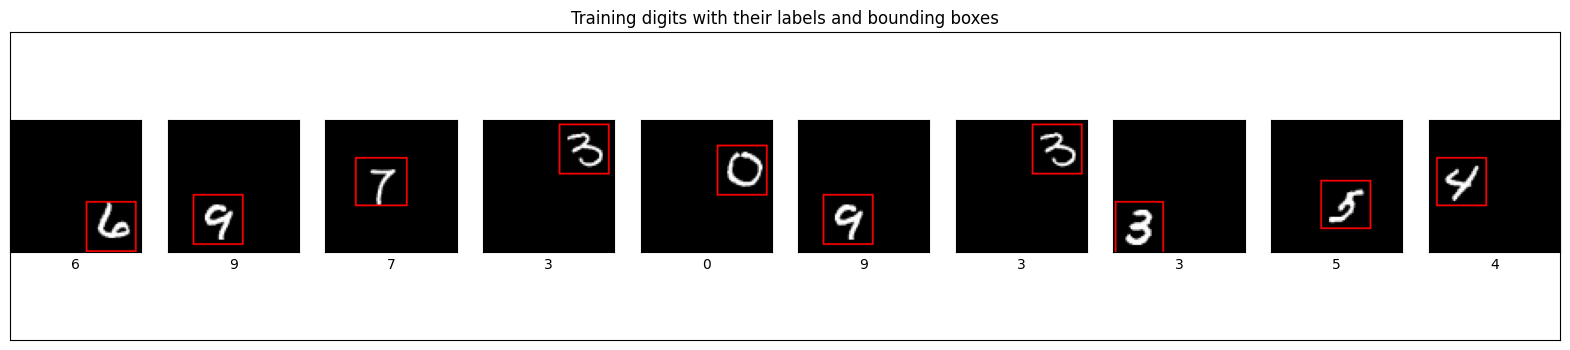

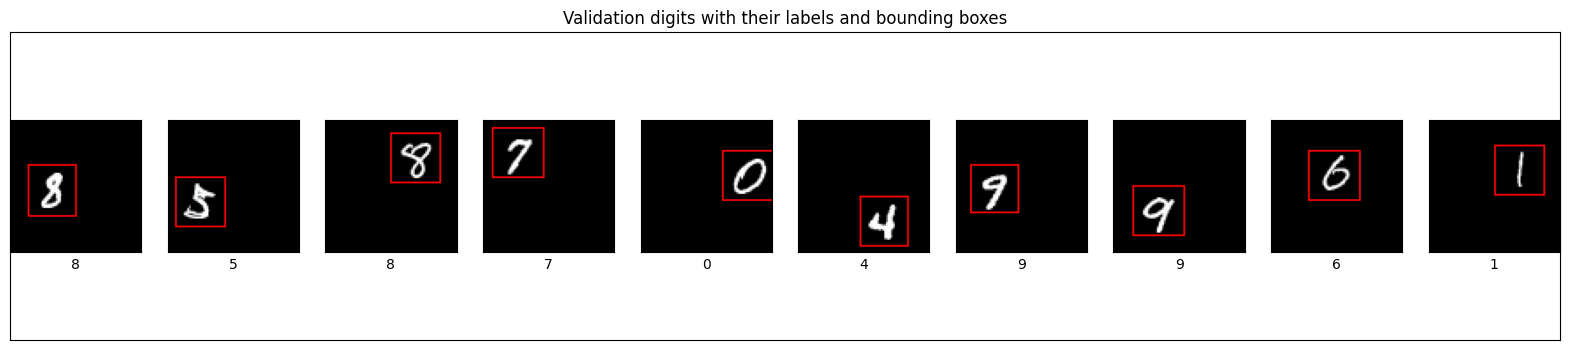

In [4]:
utils.display_digits_with_boxes(train_digits, train_labels, train_labels, np.array([]),
                                train_bboxes, 'Training digits with their labels and bounding boxes')
utils.display_digits_with_boxes(val_digits, val_labels, val_labels, np.array([]),
                                val_bboxes, 'Validation digits with their labels and bounding boxes')

## Model creation

We use the functional API (not the sequential one) to build the model. The reason is that there are different outputs and hence the sequential is not suitable.

In [5]:
def cnn_network(input_layer: Input) -> Model:
    """
    Creates the CNN network for the specified input layer.
    CNN and pooling layers. Then a dense layer is added at the end of the network.
    :param input_layer: input layer of the network
    :return: the output layer of the network
    """
    x = (ks.layers.Conv2D(16, activation='relu', kernel_size=3, 
                         input_shape=(75, 75, 1))  # 75x75 pixels in grayscale
         (input_layer))
    x = ks.layers.MaxPooling2D((2, 2))(x)
    x = ks.layers.Conv2D(32, activation='relu', kernel_size=3)(x)
    x = ks.layers.MaxPooling2D((2, 2))(x)
    x = ks.layers.Conv2D(64, activation='relu', kernel_size=3)(x)
    x = ks.layers.MaxPooling2D((2, 2))(x)
    # Takes the CNN network, flattens it to a 1D tensor and adds one dense layer
    x = ks.layers.Flatten()(x)
    x = ks.layers.Dense(128, activation='relu')(x)
    return x


def classifier_output(cnn: Model) -> Model:
    """
    This is the first output of the network.
    Takes the CNN and adds a softmax dense layer to classify the digit.
    :param cnn: the CNN network
    :return: the output layer of the classifier
    """
    return ks.layers.Dense(10, activation='softmax', name='classifier')(cnn)


def bounding_box_regression_output(cnn_network: Model) -> Model:
    """
    This is the second output of the network.
    Takes the CNN and adds 4 regression outputs for the bounding box (rectangle).
    :param cnn_network: the CNN network
    :return: the output layer of the bounding box regressor
    """
    bounding_box_regression_output = ks.layers.Dense(units=4, name='bounding_box')(cnn_network)
    return bounding_box_regression_output


def final_model(input_layer: Input) -> Model:
    """
    Creates the final model with an input layer and two output layers (classification and 4 regressions).
    :param input_layer: the input layer of the network
    :return: the final model
    """
    cnn = cnn_network(input_layer)
    classification_output = classifier_output(cnn)
    bounding_box = bounding_box_regression_output(cnn)
    # The final network has two outputs
    return ks.Model(inputs=input_layer, outputs=[classification_output, bounding_box])


def build_and_compile_model(input_layer: Input) -> Model:
    """
    Builds and compiles the final model
    :param input_layer: the input layer of the network
    :return: the compiled model
    """
    model = final_model(input_layer)
    # This model has two outputs, so two loss functions must be defined.
    # Cross entropy for the classifier and MSE for the 4 regressors.
    losses = {'classifier': 'categorical_crossentropy', 'bounding_box': 'mse'}
    # The same for the metrics.
    metrics = {'classifier': 'acc', 'bounding_box': 'mse'}
    model.compile(optimizer='adam', loss=losses, metrics=metrics)
    return model


# Input layer comprises images of 75x75 pixels in grayscale (one color)
inputs = tf.keras.layers.Input(shape=(75, 75, 1,))
model = build_and_compile_model(inputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 75, 75, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 73, 73, 16)           160       ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 36, 36, 16)           0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 conv2d_1 (Conv2D)           (None, 34, 34, 32)           4640      ['max_pooling2d[0][0]']   

## Model training

Let's train the model for 5 epochs.

In [6]:
history = model.fit(train_dataset, validation_data=val_dataset, epochs=5)

Epoch 1/5


1593/1593 [==============================] - 80s 48ms/step - loss: 0.6343 - classifier_loss: 0.6182 - bounding_box_loss: 0.0161 - classifier_acc: 0.7880 - bounding_box_mse: 0.0161 - val_loss: 0.2431 - val_classifier_loss: 0.2359 - val_bounding_box_loss: 0.0071 - val_classifier_acc: 0.9242 - val_bounding_box_mse: 0.0071
Epoch 2/5
1593/1593 [==============================] - 83s 52ms/step - loss: 0.1642 - classifier_loss: 0.1597 - bounding_box_loss: 0.0045 - classifier_acc: 0.9505 - bounding_box_mse: 0.0045 - val_loss: 0.1518 - val_classifier_loss: 0.1485 - val_bounding_box_loss: 0.0034 - val_classifier_acc: 0.9558 - val_bounding_box_mse: 0.0034
Epoch 3/5
1593/1593 [==============================] - 86s 54ms/step - loss: 0.1142 - classifier_loss: 0.1116 - bounding_box_loss: 0.0026 - classifier_acc: 0.9659 - bounding_box_mse: 0.0026 - val_loss: 0.0951 - val_classifier_loss: 0.0932 - val_bounding_box_loss: 0.0019 - val_classifier_acc: 0.9694 - val_bounding_box_mse: 0.0019
Epoch 4/5
1593/15

## Model evaluation

We evaluate the model's performance with the test dataset.

In [11]:
if get_ipython().__class__.__module__.startswith('google.colab'):
  metrics = model.evaluate(test_dataset, steps=1)
  print(f"Evaluation with the test dataset:\n"
        f"\t - Loss={metrics[0]:.4f}.\n"
        f"\t - Classification accuracy={metrics[2]:.4f}.\n"
        f"\t - Bounding box MSE={metrics[1]:.4f}.")
else:
  loss, classification_loss, bounding_box_loss, classification_accuracy, bounding_box_mse = (
      model.evaluate(test_dataset, steps=1))
  print(f"Evaluation with the test dataset:\n"
        f"\t - Loss={loss:.4f}.\n"
        f"\t - Classification loss={classification_loss:.4f}.\n"
        f"\t - Bounding box loss={bounding_box_loss:.4f}.\n"
        f"\t - Classification accuracy={classification_accuracy:.4f}.\n"
        f"\t - Bounding box MSE={bounding_box_mse:.4f}.")  

1/1 [==============================] - 4s 4s/step - loss: 0.0631 - classifier_loss: 0.0616 - bounding_box_loss: 0.0015 - classifier_acc: 0.9803 - bounding_box_mse: 0.0015
Evaluation with the test dataset:
	 - Loss=0.0631.
	 - Classification loss=0.0616.
	 - Bounding box loss=0.0015.
	 - Classification accuracy=0.9803.
	 - Bounding box MSE=0.0015.


## Model prediction

Let's visualize how the model predicts the label of each digit and its location.

313/313 [==============================] - 6s 19ms/step


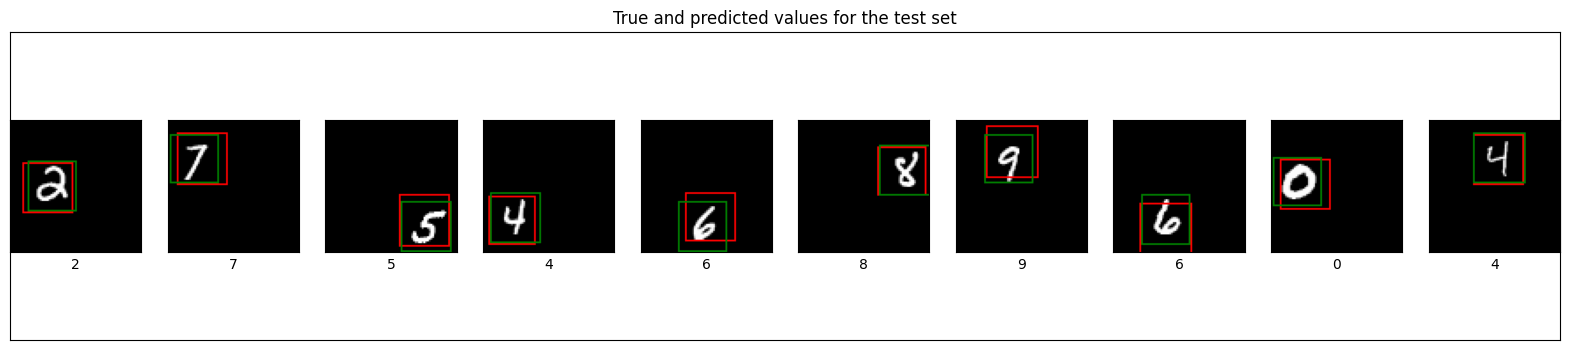

In [9]:
predictions_classifier_proba, predicted_bounding_boxes = model.predict(test_digits)
prediction_labels = np.argmax(predictions_classifier_proba, axis=1)  # get the index of the highest probability (the predicted label/digit)
utils.display_digits_with_boxes(test_digits, prediction_labels, test_labels,
                                predicted_bounding_boxes, test_bboxes, 'True and predicted values for the test set')

## ✨ Questions ✨ 

1. How many parameters does this network use? Do you think the model has a lot of parameters?
2. Do you think it has reasonable performance?
3. Do you think it could be improved if we add more epochs in the training process? Why?
4. What could be done if object detection is difficult (e.g., objects are hard to recognize and image background makes it hard to localize the objects) and performance is not the expected one?

### Answers

*Write your answers here.* 

